# Implementation on Qibo

### First way, build up the trotter decomposition directly from the Hamiltonian

#### Imports

In [2]:
from qibo import hamiltonians, models
from qibo.hamiltonians import SymbolicHamiltonian
from qibo.symbols import X, Y,Z,I
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n_qubits=3
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    # we redefine the new order of qubits (following qibo and qiskit)
    t_onebody[(n_qubits-i-1,n_qubits-j-1)]=values[a]
    #t_onebody[(i,j)]=values[a]
    
    if i==j:
        print(values[a])
print(t_onebody)


1.5678999999999998
1.5678999999999998
4.8797
{(np.int64(2), np.int64(2)): np.float64(1.5678999999999998), (np.int64(2), np.int64(1)): np.float64(1.0430999999999995), (np.int64(2), np.int64(0)): np.float64(-3.763858685577873), (np.int64(1), np.int64(2)): np.float64(1.0430999999999995), (np.int64(1), np.int64(1)): np.float64(1.5678999999999998), (np.int64(1), np.int64(0)): np.float64(3.763858685577873), (np.int64(0), np.int64(2)): np.float64(-3.763858685577873), (np.int64(0), np.int64(1)): np.float64(3.763858685577873), (np.int64(0), np.int64(0)): np.float64(4.8797)}


#### Define the $H_Q$ Hamiltonian

In [4]:
terms = []

terms_diagonal=[]

for (i,j),value in t_onebody.items():
    if i!=j:    
        terms.append(0.25*value * (Y(i) * Y(j)))
        terms.append(0.25*value *X(i)*X(j))

    elif i==j:
        # we convert the projector from Z+I to I-Z, because in qibo our 1 is 0 and viceversa
        terms.append(0.5*value*(-1*Z(i)+I(i)))
        terms_diagonal.append(0.5*value*(-1*Z(i)+I(i)))

[Qibo 0.2.18|INFO|2025-06-23 12:57:56]: Using qibojit (numba) backend on /CPU:0


In [4]:
form=sum(terms)
form_diagonal=sum(terms_diagonal)
print(form)

0.940964671394468*X0*X1 - 0.940964671394468*X0*X2 + 0.940964671394468*X1*X0 + 0.260775*X1*X2 - 0.940964671394468*X2*X0 + 0.260775*X2*X1 + 0.940964671394468*Y0*Y1 - 0.940964671394468*Y0*Y2 + 0.940964671394468*Y1*Y0 + 0.260775*Y1*Y2 - 0.940964671394468*Y2*Y0 + 0.260775*Y2*Y1 - 11.70515*(I0 - Z0) - 13.36105*(I1 - Z1) - 13.36105*(I2 - Z2)


In [5]:
hamiltonian_qq=SymbolicHamiltonian(form=form,nqubits=n_qubits)

hamiltonian_diagonal=SymbolicHamiltonian(form=form_diagonal,nqubits=n_qubits)


In [6]:
print(hamiltonian_qq.matrix)

[Qibo 0.2.18|WARNING|2025-06-10 17:00:35]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[[  0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j]
 [  0.        +0.j -26.7221    +0.j   1.0431    +0.j   0.        +0.j
   -3.76385869+0.j   0.        +0.j   0.        +0.j   0.        +0.j]
 [  0.        +0.j   1.0431    +0.j -26.7221    +0.j   0.        +0.j
    3.76385869+0.j   0.        +0.j   0.        +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j -53.4442    +0.j
    0.        +0.j   3.76385869+0.j  -3.76385869+0.j   0.        +0.j]
 [  0.        +0.j  -3.76385869+0.j   3.76385869+0.j   0.        +0.j
  -23.4103    +0.j   0.        +0.j   0.        +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j   3.76385869+0.j
    0.        +0.j -50.1324    +0.j   1.0431    +0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j   0.        +0.j  -3.76385869+0.j
    0.        +0.j   1.0431    +0.j -50.1324    +0.j   0.        +0.j]
 [  0.       

In [7]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_qq.matrix)[2**(i-1),2**(j-1)]} \n')
        
### We got exactly the same Hamiltonian!

i=0,j=0 ->(-26.722099999999998+0j) 

i=0,j=1 ->(1.0430999999999995+0j) 

i=0,j=2 ->(-3.763858685577873+0j) 

i=1,j=0 ->(1.0430999999999995+0j) 

i=1,j=1 ->(-26.722099999999998+0j) 

i=1,j=2 ->(3.763858685577873+0j) 

i=2,j=0 ->(-3.763858685577873+0j) 

i=2,j=1 ->(3.763858685577873+0j) 

i=2,j=2 ->(-23.4103+0j) 



#### Get the driver Hamiltonian

In [8]:
terms = []

external_field_coupling_o18=-26.7220999999999

terms.append(0.5*external_field_coupling_o18*(-1*Z(n_qubits-1)+I(n_qubits-1)))


form=sum(terms)
print(form)

hamiltonian_driver=SymbolicHamiltonian(form=form,nqubits=n_qubits)



-13.36105*(I2 - Z2)


In [9]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_driver.matrix)[2**(i-1),2**(j-1)]} \n')

[Qibo 0.2.18|WARNING|2025-06-10 17:00:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


i=0,j=0 ->(-26.7220999999999+0j) 

i=0,j=1 ->0j 

i=0,j=2 ->0j 

i=1,j=0 ->0j 

i=1,j=1 ->0j 

i=1,j=2 ->0j 

i=2,j=0 ->0j 

i=2,j=1 ->0j 

i=2,j=2 ->0j 



In [ ]:
#### lOAD THE CIRCUIT

In [10]:
from qibo import Circuit, gates
import json

# --- 1. Load gate list ---
def load_gate_list(filename="gate_list.json"):
    with open(filename, "r") as f:
        return json.load(f)



def remap_qubits(qubit_indices, n_qubits):
    return [n_qubits - q - 1 for q in qubit_indices]

def gate_from_label(label, qubit_indices, param=None):
    if label == "h":
        return gates.H(qubit_indices[0])
    elif label == "x":
        return gates.X(qubit_indices[0])
    elif label == "rz":
        return gates.RZ(qubit_indices[0], theta=param)
    elif label == "rx":
        return gates.RX(qubit_indices[0], theta=param)
    elif label == "ry":
        return gates.RY(qubit_indices[0], theta=param)
    elif label in {"cx", "cnot"}:
        return gates.CNOT(*qubit_indices)
    elif label == "cz":
        return gates.CZ(*qubit_indices)
    elif label in {"ccx", "toffoli"}:
        return gates.Toffoli(*qubit_indices)
    elif label == "u3":
        return gates.U3(qubit_indices[0], *param)
    else:
        raise ValueError(f"Unsupported gate: {label}")

def build_qibo_circuit_from_gate_list(gate_list, n_qubits):
    circuit = Circuit(n_qubits,density_matrix=True)
    for label, qubit_indices, param in gate_list:
        remapped_indices = remap_qubits(qubit_indices, n_qubits)
        gate = gate_from_label(label, remapped_indices, param)
        circuit.add(gate)
    return circuit

In [11]:
gate_list = load_gate_list("data/qa_circuit.json")

qibo_circuit = build_qibo_circuit_from_gate_list(gate_list, n_qubits=3)
#qibo_circuit.add(gates.M(*range(n_qubits)))
qibo_circuit.draw()

0:     ───────────────────────H─X─RZ─X────────X─RZ─X───────────────H─RZ─H─X─R ...
1:     ─H──────────────X─RZ─X───|────|────────o────o─H─RZ─H─X─RZ─X────────|── ...
2:     ─RZ─H─RZ─H─RZ─H─o────o───o────o─H─RZ─H───────────────o────o────────o── ...

0: ... Z─X────────X─RZ─X───────────────H─RZ─H─X─RZ─X────────X─RZ─X─────────── ...
1: ... ──|────────o────o─H─RZ─H─X─RZ─X────────|────|────────o────o─H─RZ─H─X─R ...
2: ... ──o─H─RZ─H───────────────o────o────────o────o─H─RZ─H───────────────o── ...

0: ... ────H─RZ─H─X─RZ─X────────X─RZ─X───────────────H─RZ─H─X─RZ─X────────X─R ...
1: ... Z─X────────|────|────────o────o─H─RZ─H─X─RZ─X────────|────|────────o── ...
2: ... ──o────────o────o─H─RZ─H───────────────o────o────────o────o─H─RZ─H──── ...

0: ... Z─X───────────────H─RZ─H─X─RZ─X────────X─RZ─X───────────────H─RZ─H─X─R ...
1: ... ──o─H─RZ─H─X─RZ─X────────|────|────────o────o─H─RZ─H─X─RZ─X────────|── ...
2: ... ───────────o────o────────o────o─H─RZ─H───────────────o────o────────o── ...

0: ... Z─X──

In [12]:
from qibo import models, gates
from copy import deepcopy

def amplify_cnots_qibo(circuit, cnot_multiples=[2, 4, 6, 8]):
    """
    Amplify noise in a Qibo circuit by repeating each CNOT gate multiple (even) times.
    """
    amplified_circuits = []

    for m in cnot_multiples:
        new_circuit = models.Circuit(circuit.nqubits,density_matrix=True)

        for gate in circuit.queue:
            if isinstance(gate, gates.CNOT):
                control = gate.qubits[0]
                target = gate.qubits[1]
                # this is the correct CNOT
                new_circuit.add(gates.CNOT(control, target))
                for _ in range(m):
                    new_circuit.add(gates.CNOT(control, target))
            else:
                new_circuit.add(deepcopy(gate))

        amplified_circuits.append(new_circuit)
        
    return amplified_circuits

In [13]:
amplified_circuits=amplify_cnots_qibo(circuit=qibo_circuit)

In [14]:
qibo_circuit.draw()

0:     ───────────────────────H─X─RZ─X────────X─RZ─X───────────────H─RZ─H─X─R ...
1:     ─H──────────────X─RZ─X───|────|────────o────o─H─RZ─H─X─RZ─X────────|── ...
2:     ─RZ─H─RZ─H─RZ─H─o────o───o────o─H─RZ─H───────────────o────o────────o── ...

0: ... Z─X────────X─RZ─X───────────────H─RZ─H─X─RZ─X────────X─RZ─X─────────── ...
1: ... ──|────────o────o─H─RZ─H─X─RZ─X────────|────|────────o────o─H─RZ─H─X─R ...
2: ... ──o─H─RZ─H───────────────o────o────────o────o─H─RZ─H───────────────o── ...

0: ... ────H─RZ─H─X─RZ─X────────X─RZ─X───────────────H─RZ─H─X─RZ─X────────X─R ...
1: ... Z─X────────|────|────────o────o─H─RZ─H─X─RZ─X────────|────|────────o── ...
2: ... ──o────────o────o─H─RZ─H───────────────o────o────────o────o─H─RZ─H──── ...

0: ... Z─X───────────────H─RZ─H─X─RZ─X────────X─RZ─X───────────────H─RZ─H─X─R ...
1: ... ──o─H─RZ─H─X─RZ─X────────|────|────────o────o─H─RZ─H─X─RZ─X────────|── ...
2: ... ───────────o────o────────o────o─H─RZ─H───────────────o────o────────o── ...

0: ... Z─X──

In [15]:
amplified_circuits[1].draw()

0:     ───────────────────────────────────────H─X─X─X─X─X─RZ─X─X─X─X─X─────── ...
1:     ─H──────────────X─X─X─X─X─RZ─X─X─X─X─X───|─|─|─|─|────|─|─|─|─|─────── ...
2:     ─RZ─H─RZ─H─RZ─H─o─o─o─o─o────o─o─o─o─o───o─o─o─o─o────o─o─o─o─o─H─RZ─H ...

0: ... ─X─X─X─X─X─RZ─X─X─X─X─X───────────────────────────────H─RZ─H─X─X─X─X─X ...
1: ... ─o─o─o─o─o────o─o─o─o─o─H─RZ─H─X─X─X─X─X─RZ─X─X─X─X─X────────|─|─|─|─| ...
2: ... ───────────────────────────────o─o─o─o─o────o─o─o─o─o────────o─o─o─o─o ...

0: ... ─RZ─X─X─X─X─X────────X─X─X─X─X─RZ─X─X─X─X─X─────────────────────────── ...
1: ... ────|─|─|─|─|────────o─o─o─o─o────o─o─o─o─o─H─RZ─H─X─X─X─X─X─RZ─X─X─X─ ...
2: ... ────o─o─o─o─o─H─RZ─H───────────────────────────────o─o─o─o─o────o─o─o─ ...

0: ... ────H─RZ─H─X─X─X─X─X─RZ─X─X─X─X─X────────X─X─X─X─X─RZ─X─X─X─X─X─────── ...
1: ... X─X────────|─|─|─|─|────|─|─|─|─|────────o─o─o─o─o────o─o─o─o─o─H─RZ─H ...
2: ... o─o────────o─o─o─o─o────o─o─o─o─o─H─RZ─H────────────────────────────── ...

0: ... ─────

Clean Case

In [16]:
from qibo import Circuit, set_backend
from qibo.noise import NoiseModel, DepolarizingError,ThermalRelaxationError

energy_vs_errors=[]

t1 = 197*10**-6
t2 = 119*10**-6
gate_time = 68*10**-9


# Set backend
backend=set_backend("numpy")  # or 'qibo', 'tensorflow'...

# Create a basic noise model (depolarizing noise)
noise_model = NoiseModel()


noisy_circuit=noise_model.apply(qibo_circuit)


# Simulate the circuit to get statevector (with noise disables pure state use)
result = noisy_circuit()

clean_state=result.state()
# Compute energy ⟨ψ|H|ψ⟩
energy = hamiltonian_qq.expectation(result.state())
energy_vs_errors.append(energy)
print(energy)

[Qibo 0.2.18|INFO|2025-06-10 17:01:01]: Using numpy backend on /CPU:0


-31.334163248200888


With Noise

In [ ]:
from qibo import Circuit, set_backend
from qibo.noise import NoiseModel, DepolarizingError,ThermalRelaxationError

energy_vs_errors=[]

t1 = 197*10**-6
t2 = 119*10**-6
gate_time = 68*10**-9


# Set backend
backend=set_backend("numpy")  # or 'qibo', 'tensorflow'...

# Create a basic noise model (depolarizing noise)
noise_model = NoiseModel()
noise_model.add(gates.RZ, DepolarizingError(0.0002977))
noise_model.add(gates.H, DepolarizingError(0.0002977))
noise_model.add(gates.CNOT, DepolarizingError(0.00268))

noise_model.add(ThermalRelaxationError(t1=t1,t2=t2,time=gate_time))

noisy_circuit=noise_model.apply(qibo_circuit)


# Simulate the circuit to get statevector (with noise disables pure state use)
result = noisy_circuit()

# Compute energy ⟨ψ|H|ψ⟩
energy = hamiltonian_qq.expectation(result.state())
energy_vs_errors.append(energy)
print(energy)

[Qibo 0.2.18|INFO|2025-06-10 17:01:44]: Using numpy backend on /CPU:0


-33.99167103249545


Compute the ZNE

In [32]:
for circuit in amplified_circuits:
    t1 = 197*10**-6
    t2 = 119*10**-6
    gate_time = 68*10**-9


    # Set backend
    backend=set_backend("numpy")  # or 'qibo', 'tensorflow'...

    # Create a basic noise model (depolarizing noise)
    noise_model = NoiseModel()
    noise_model.add(gates.RZ, DepolarizingError(0.0002977))
    noise_model.add(gates.H, DepolarizingError(0.0002977))
    noise_model.add(gates.CNOT, DepolarizingError(0.00268))

    noise_model.add(ThermalRelaxationError(t1=t1,t2=t2,time=gate_time))

    noisy_circuit=noise_model.apply(circuit)


    # Simulate the circuit to get statevector (with noise disables pure state use)
    result = noisy_circuit()

    # Compute energy ⟨ψ|H|ψ⟩
    energy = hamiltonian_qq.expectation(result.state())
    energy_vs_errors.append(energy)
    print(energy)

[Qibo 0.2.18|INFO|2025-06-10 15:59:59]: Using numpy backend on /CPU:0


[Qibo 0.2.18|INFO|2025-06-10 16:00:04]: Using numpy backend on /CPU:0


-36.13626917376179


[Qibo 0.2.18|INFO|2025-06-10 16:00:09]: Using numpy backend on /CPU:0


-36.903529185708955


[Qibo 0.2.18|INFO|2025-06-10 16:00:18]: Using numpy backend on /CPU:0


-37.25985653077778
-37.46971587841236


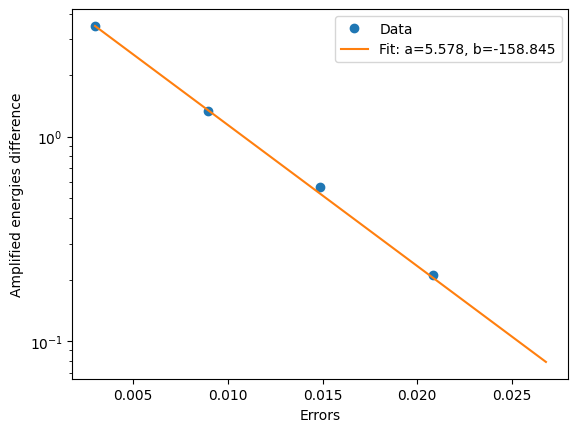

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Your data (example)
errors = 0.002977 * np.array([1, 3, 5, 7, 9])
amplified_energies = np.asarray(energy_vs_errors)

# Define y data as difference from last value
y = amplified_energies - amplified_energies[-1]

# Exponential function to fit
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Fit curve
popt, pcov = curve_fit(exp_func, errors, y, p0=(1, 1))

# Plot data points
plt.plot(errors, y, 'o', label='Data')

# Plot fitted curve
x_fit = np.linspace(errors.min(), errors.max(), 100)
y_fit = exp_func(x_fit, *popt)
plt.plot(x_fit, y_fit, '-', label=f'Fit: a={popt[0]:.3f}, b={popt[1]:.3f}')

plt.semilogy()
plt.xlabel('Errors')
plt.ylabel('Amplified energies difference')
plt.legend()
plt.show()

In [34]:
print(energy_vs_errors[-1]+popt[0])

-31.89142721756376


#### Analysis of the noise

Only 2q depolarization

In [32]:
from qibo import Circuit, set_backend
from qibo.noise import NoiseModel, DepolarizingError,ThermalRelaxationError
from qibo.quantum_info import fidelity

energies_2q=[]
fidelities_2q=[]
t1 = 197*10**-6
t2 = 119*10**-6
gate_time = 68*10**-9

depolarization_cnot=np.linspace(10**-5,0.1,20)

energies=[]
fidelities=[]
for value in depolarization_cnot:
    # Set backend
    print(value)
    backend=set_backend("qibotn")  # or 'qibo', 'tensorflow'...

    # Create a basic noise model (depolarizing noise)
    noise_model = NoiseModel()
    # noise_model.add(gates.RZ, DepolarizingError(0.0002977))
    # noise_model.add(gates.H, DepolarizingError(0.0002977))
    noise_model.add(gates.CNOT, DepolarizingError(value))

    #noise_model.add(ThermalRelaxationError(t1=t1,t2=t2,time=gate_time))

    noisy_circuit=noise_model.apply(qibo_circuit)


    # Simulate the circuit to get statevector (with noise disables pure state use)
    result = noisy_circuit()
    noisy_circuit.draw()
    # Compute energy ⟨ψ|H|ψ⟩
    energy = hamiltonian_qq.expectation(result.state())
    energies_2q.append(energy)
    fidelities_2q.append(1-fidelity(result.state(),clean_state))
    print(energy,1-fidelity(result.state(),clean_state))

1e-05


MissingBackend: The 'qibotn' backends' provider is not available. Check that a Python package named 'qibotn' is installed, and it is exposing valid Qibo backends.

In [ ]:
from qibo.models.error_mitigation import ZNE




# Mitigated expected value
estimate = ZNE(
    circuit=qibo_circuit,
    observable=hamiltonian_diagonal,
    noise_levels=np.arange(5),
    noise_model=noise_model,
    insertion_gate='CNOT',
    nshots=100,
    backend=backend,
)
print(estimate)

TypeError: SymbolicTerm.__call__() missing 3 required positional arguments: 'backend', 'state', and 'nqubits'

 To measure in Qibo we have to use the old way, changing the basis and then compute each element of the Hamiltonian (XX,YY,Z) in different basis

In [ ]:
expectation_value = hamiltonian_qq.expectation(final_state)
print("⟨H⟩ =", expectation_value)

#### Using a trotter decomposition of gates in a quantum circuit

In [29]:
tf=10
time_steps=100
time=np.linspace(0,tf,time_steps)
scheduler=1.2*time/tf-0.2*(time/tf)**2

for i,t in enumerate(time):
    
    hamiltonian_t=hamiltonian_driver*(1-scheduler[i])+scheduler[i]*hamiltonian_qq
    if i==0:
        circuit=hamiltonian_t.circuit(dt=tf/time_steps)
    else:
        circuit+=(hamiltonian_t.circuit(dt=tf/time_steps))
    

In [30]:
final_state_clean=circuit(initial_state)

In [31]:
e_trotterize=hamiltonian_qq.expectation(state=final_state_clean.state())

In [32]:
print(np.abs((e_trotterize-egs)/egs))

0.0004044160052220449


#### Simulate with noise

We need to build the circuit in a different way, because we need to implement

In [ ]:
from qibo.hamiltonians.terms import TermGroup
from qibo import Circuit,gates
from itertools import chain

def create_a_circuit_from_hamiltonian_with_noise(hamiltonian,dt,accelerators=None):
    
    groups=TermGroup.from_terms(hamiltonian.terms)
    circuit=Circuit(hamiltonian.nqubits,accelerators=accelerators,density_matrix=True)
    circuit.add(group.term.expgate(dt/2.0) for group in chain(groups,groups[::-1]))
    
    return circuit




In [42]:
tf=10
time_steps=100
time=np.linspace(0,tf,time_steps)
scheduler=1.*time/tf-0.*(time/tf)**2

circuit=Circuit(nqubits=n_qubits,density_matrix=True)
circuit.add(gate=gates.X(n_qubits-1))

for i,t in enumerate(time):
    
    hamiltonian_t=hamiltonian_driver*(1-scheduler[i])+scheduler[i]*hamiltonian_qq

    circuit+=create_a_circuit_from_hamiltonian_with_noise(hamiltonian=hamiltonian_t,dt=tf/time_steps)

In [43]:
from qibo import Circuit, gates
from qibo.noise import IBMQNoiseModel

parameters = {
    "t1": {"0": 250*1e-06, "1": 240*1e-06},
    "t2": {"0": 150*1e-06, "1": 160*1e-06},
    "gate_times" : (200*1e-9, 400*1e-9),
    "excited_population" : 0,
    "depolarizing_one_qubit" : 4.000e-4,
    "depolarizing_two_qubit": 1.500e-4,
    "readout_one_qubit" : {"0": (0.022, 0.034), "1": (0.015, 0.041)},
    }

noise_model = IBMQNoiseModel()
noise_model.from_dict(parameters)
noisy_circuit = noise_model.apply(circuit)



In [44]:


final_state=noisy_circuit()





In [45]:
energy_noise=hamiltonian_qq.expectation(final_state.state())

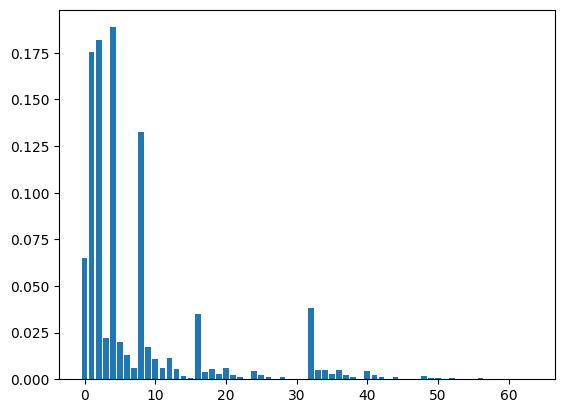

In [46]:
plt.bar(x=np.arange(2**n_qubits),height=np.diag(final_state.state()))
plt.show()




In [47]:
print(np.abs((energy_noise-egs)/egs))

0.04254650861183573


##### What if we remove basis term outside the single particle space?

1
2
4
8
16
32


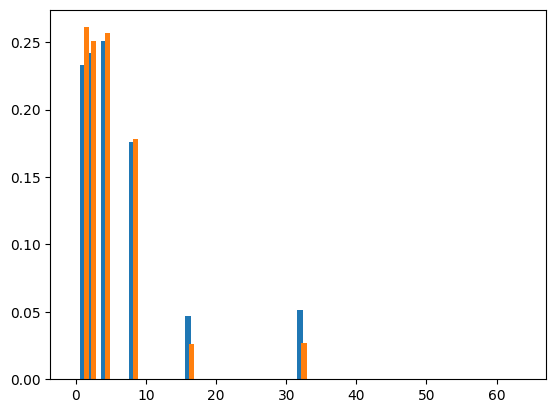

0.9054631780295144
0.6808698540396914


In [48]:
from qibo.quantum_info import fidelity

sp_density_matrix=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)

for i in range(1,n_qubits+1):
    print(2**(i-1))
    for j in range(1,n_qubits+1):

        sp_density_matrix[2**(i-1),2**(j-1)]=final_state.state()[2**(i-1),2**(j-1)]

sp_density_matrix_normalized=sp_density_matrix/np.trace(sp_density_matrix)

plt.bar(x=np.arange(2**n_qubits),height=np.diag(sp_density_matrix_normalized))
plt.bar(x=np.arange(2**n_qubits)+0.5,height=final_state_clean.state().conjugate()*final_state_clean.state())
plt.show()

final_state_clean_densitymatrix=np.outer(final_state_clean.state().conjugate(),final_state_clean.state())

print(fidelity(sp_density_matrix_normalized,final_state_clean_densitymatrix))
print(fidelity(final_state.state(),final_state_clean_densitymatrix))


In [88]:
print(hamiltonian_qq.expectation(state=sp_density_matrix_normalized))



-11.820405093953408


#### What if we consider the error correction?

In [67]:
tf=10
time_steps=100
time=np.linspace(0,tf,time_steps)
scheduler=time/tf

circuit=Circuit(n_qubits,density_matrix=True)
# we initialize the state
circuit.add(gate=gates.X(5))
circuit.draw()
for i,t in enumerate(time):
    
    hamiltonian_t=hamiltonian_driver*(1-scheduler[i])+scheduler[i]*hamiltonian_qq
    if i==0:
        circuit+=create_a_circuit_from_hamiltonian_with_noise(hamiltonian=hamiltonian_t,dt=tf/time_steps)
    else:
        circuit+=create_a_circuit_from_hamiltonian_with_noise(hamiltonian=hamiltonian_t,dt=tf/time_steps)

#circuit.add(gates.M(*range(n_qubits)))

circuit.draw()
    


0: ───
1: ───
2: ───
3: ───
4: ───
5: ─X─
0:     ───────U───────U───U─U─U─────────────────────────U─U─U───U───────U─U── ...
1:     ───────U─U─────|───|─|─|───────U─U─U─U─U─U───────|─|─|───|─────U─U─U─U ...
2:     ─────────|─────|─U─|─U─|───U─U─|─U─|─|─U─|─U─U───|─U─|─U─|─────|─────| ...
3:     ─────────|───U─U─|─|───|─U─U─|─|───U─U───|─|─U─U─|───|─|─U─U───|─────| ...
4:     ─────────U─U─U───U─|───U─|───|─|─────────|─|───|─U───|─U───U─U─U─────U ...
5:     ─X─U─U─────U───────U─────U───U─U─────────U─U───U─────U───────U──────── ...

0: ... ─────U───U─U─U─────────────────────────U─U─U───U───────U─U─────────U─U ...
1: ... ─────|───|─|─|───────U─U─U─U─U─U───────|─|─|───|─────U─U─|───────U─|─| ...
2: ... ─────|─U─|─U─|───U─U─|─U─|─|─U─|─U─U───|─U─|─U─|─────|───U─────U─|─|─| ...
3: ... ───U─U─|─|───|─U─U─|─|───U─U───|─|─U─U─|───|─|─U─U───|─────U───|─|─|─U ...
4: ... ─U─U───U─|───U─|───|─|─────────|─|───|─U───|─U───U─U─U─────U─U─U─U─|── ...
5: ... ─U───────U─────U───U─U─────────U─U───U─────U────

In [89]:
import numpy as np
from qibo.noise import NoiseModel, KrausError
from qibo import gates
from itertools import product

# Single-qubit Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
paulis = [I, X, Y, Z]

def one_qubit_depolarizing_kraus(r1q):
    p = r1q
    K0 = np.sqrt(1 - 3 * p / 4) * I
    Ks = [K0] + [np.sqrt(p / 4) * P for P in [X, Y, Z]]
    return Ks

def two_qubit_depolarizing_kraus(r2q):
    p = r2q
    K00 = np.sqrt(1 - 15 * p / 16) * np.kron(I, I)
    Ks = [K00]
    for i in range(1, 4):
        for j in range(4):
            Kij = np.sqrt(p / 16) * np.kron(paulis[i], paulis[j])
            Ks.append(Kij)
    return Ks

# Example: Aria 1 noise parameters
r1q = 0.0005
r2q = 0.0133

noise = NoiseModel()

# Add noise to all 1-qubit gates
noise.add(KrausError(one_qubit_depolarizing_kraus(r1q)), qubits=1)

# Add noise to all 2-qubit gates
noise.add(KrausError(two_qubit_depolarizing_kraus(r2q)), qubits=2)

In [90]:
from qibo import Circuit, gates

import qibo
from qibo.backends import NumpyBackend




noisy_circuit = noise.apply(circuit)



In [91]:
noisy_circuit.draw()

0:     ───────U───────────U───U─U─U─────────────────────────────────────U─U─U ...
1:     ───────U─K─U─K─────|───|─|─|───────U─K─U─K─U─K─U─K─U─K─U─K───────|─|─| ...
2:     ───────────|───────|─U─|─U─|───U─U─|───U───|───|───U───|───U─U───|─U─| ...
3:     ───────────|─────U─U─|─|───|─U─U─|─|───────U───U───────|───|─U─U─|───| ...
4:     ───────────U───U─U───U─|───U─|───|─|───────────────────|───|───|─U───| ...
5:     ─X─U─U─────────U───────U─────U───U─U───────────────────U───U───U─────U ...

0: ... ───U─────────U───U───────────U───U─U─U──────────────────────────────── ...
1: ... ───|─────U─K─U─K─U─K─U─K─────|───|─|─|───────U─K─U─K─U─K─U─K─U─K─U─K── ...
2: ... ─U─|─────|───────────|───────|─U─|─U─|───U─U─|───U───|───|───U───|───U ...
3: ... ─|─U─U───|───────────|─────U─U─|─|───|─U─U─|─|───────U───U───────|───| ...
4: ... ─U───U─U─U───────────U───U─U───U─|───U─|───|─|───────────────────|───| ...
5: ... ───────U─────────────────U───────U─────U───U─U───────────────────U───U ...

0: ... ─────U─

In [92]:
for gate in noisy_circuit.queue:
    print(gate)

In [93]:
final_state=noisy_circuit()

In [94]:
energy_noise=hamiltonian_qq.expectation(final_state.state())
print(energy_noise)
print(np.abs((energy_noise-egs)/egs))

-10.970764656777078
0.08054313176592974


/opt/anaconda3/envs/qutip_env/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/qutip_env/lib/python3.10/site-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


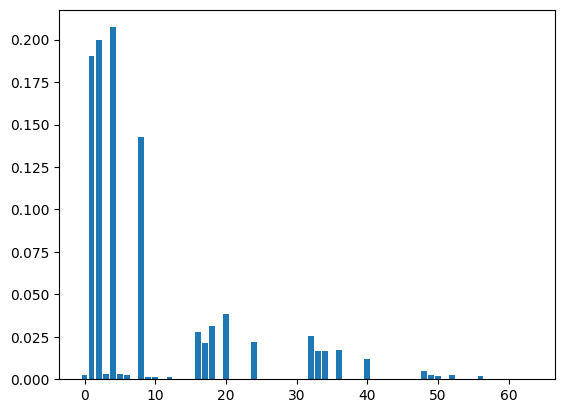

In [95]:
plt.bar(x=np.arange(2**n_qubits),height=np.diag(final_state.state()))
plt.show()


1
2
4
8
16
32


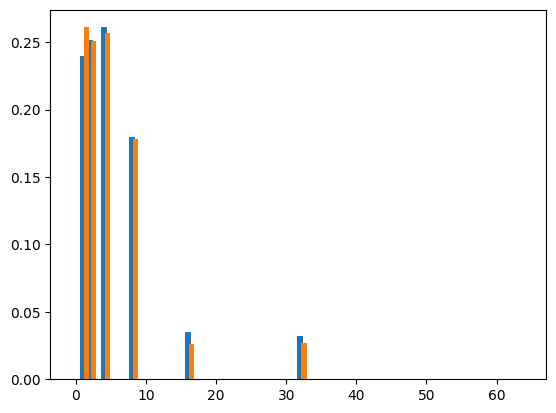

0.9908725672061774
0.7865286270809374


In [96]:
from qibo.quantum_info import fidelity

sp_density_matrix=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)

for i in range(1,n_qubits+1):
    print(2**(i-1))
    for j in range(1,n_qubits+1):

        sp_density_matrix[2**(i-1),2**(j-1)]=final_state.state()[2**(i-1),2**(j-1)]

sp_density_matrix_normalized=sp_density_matrix/np.trace(sp_density_matrix)

plt.bar(x=np.arange(2**n_qubits),height=np.diag(sp_density_matrix_normalized))
plt.bar(x=np.arange(2**n_qubits)+0.5,height=final_state_clean.state().conjugate()*final_state_clean.state())
plt.show()

final_state_clean_densitymatrix=np.outer(final_state_clean.state().conjugate(),final_state_clean.state())

print(fidelity(sp_density_matrix_normalized,final_state_clean_densitymatrix))
print(fidelity(final_state.state(),final_state_clean_densitymatrix))
